In [62]:
import os
import json
from typing import Union, List
from collections import defaultdict
import pandas as pd
################
def flatten2list(object):
    """ This function flattens objects in a nested structure and retu"""
    gather = []
    for item in object:
        if isinstance(item, (list, set)):
            gather.extend(flatten2list(item))            
        else:
            gather.append(item)
    return gather

def flatten2set(object) -> set:
    """ This function flattens objects in a nested structure and returns a set"""

    return set(flatten2list(object))

def flatten_dict_values(dictionary:dict) -> set:
    """ This function flattens objects in a nested structure and returns a set"""

    return flatten2set(dictionary.values())

def get_inventory_hlas(path='inventory_hla.json') -> dict:
    """ This function returns all the hla & locus
        available in the hla inventory
        base_dir: should be absolute path
        """
    with open(path) as json_file: 
        return json.load(json_file)

####################
class Epitope:
    """ This is a class that entails the data base [Pandas DataFrame] of all epitopes and
        all the related methods tha can be applied to this data base  """

    def __init__(self, path:str='../data/EpitopevsHLA.pickle'):
        # the path is consistent if dash_hla_3d/app.py is ran
        self.path = os.path.expanduser(path)
        # Get hlas with pdb files
        self.pdb_inventory = flatten_dict_values(get_inventory_hlas())
        self.df = pd.read_pickle(self.path) # pylint: disable=invalid-name
        self._hlavsep = None
        self._hlavsep_df = None

    def __repr__(self):
        return f""" Epitope_DB(records={len(self.df)}, columns={self.df.columns}) """

    def filter_mAb(self):
        ind = self.df.mAb == 'Yes'
        self.df = self.df[ind]
        return self
    
    def is_IgG(self):
        self.filter_isotype()
        if len(self.df != 0):
            return True
        else:
            return False

    def isotype(self, isotype:str='IgG'):
        ind = self.df.isotype.apply(lambda x: isotype == x)
        self.df = self.df[ind]
        return self

    def get_epitopes(self, value: Union[str, List[str]]):
        """ get epitope info from the df
        value: can be str or a list of strings """

        if isinstance(value, str):
            ind = self.df.Epitope == value
        else:
            ind = self.df.Epitope.apply(lambda x: x in value)
        self.df = self.df[ind]
        return self

    def ellipro(self, value):
        """ filter EpitopeDB based on desired ellipro score """
        if isinstance(value, str):
            ind = self.df.Epitope == value
        else:
            ind = self.df['ElliPro Score'].apply(lambda x: x in value)
        self.df = self.df[ind]
        return self
    
    def hlavsep(self,
                hla_allel:str='Luminex Alleles',
                only_with_pdb:bool=False, 
                ignore_hla:set =set()) -> pd.DataFrame:
        """ returns a DataFrame of HLA vs epitoes
        hla_allel [default is 'Luminex Alleles']: determines the allel type
        only_with_pdb [default is False]: If True, includes only luminex allels that pdb file 
        is available:
        only_with_pdb: Include only Luminex Alleles that pdb file is available
        { 'HLA' : {'epitopes'}} """
        
        if only_with_pdb:
            # Luminex Alleles with available pdb files
            hlas = flatten2set(self.df[hla_allel].values).intersection(self.pdb_inventory) - ignore_hla
        else:
            hlas = flatten2set(self.df[hla_allel].values)
        
        hlavsep_dict = defaultdict(list)
        for hla in hlas:
            ind = self.df[hla_allel].apply(lambda x: hla in x)
            epitopes = flatten2set(self.df[ind]['Epitope'].values)
            hlavsep_dict['HLA'].append(hla)
            hlavsep_dict['Epitope'].append(epitopes)
        self._hlavsep_df = pd.DataFrame(hlavsep_dict)
        return self._hlavsep_df

    def min_hlavsep(self, epitopes:set, ignore_hla:set=set()) -> dict:
        """ Returns the HLA vs epitope dictionary
            based on minimum number of HLA possible
            ignore_hla: ignores some hla
            format { 'HLA' : {'epitopes'} }
        """
        # Deep copy of epitopes set for later epitope removal
        _epitopes = epitopes.copy()
        hlavsep_df = self.hlavsep(only_with_pdb=True, ignore_hla=ignore_hla)
        hla_ep = defaultdict(set)
        for _ in range(10):
            intersect = hlavsep_df.Epitope.apply(
                lambda x: len(x.intersection(_epitopes))
            )
            # find the indexes with maximum value
            value_max = intersect.max()
            if value_max:
                ind_maxes = intersect == value_max
                hlavsep_max_df = hlavsep_df[ind_maxes]
                max_hla = hlavsep_max_df.HLA.values.tolist()[0]
                ind_max = hlavsep_max_df.HLA == max_hla
                set_of_ep = hlavsep_max_df[ind_max].Epitope.values[0].intersection(_epitopes)
                hla_ep[max_hla] = set_of_ep
                _epitopes.difference_update(set_of_ep)
        return dict(hla_ep)

    def epvshla2hlavsep(self, epvshla:dict) -> dict:
        """ Transform an ep vs hla dict 2 hla vs ep dict """
        hlavsep = defaultdict(set)
        for epitope, hla in epvshla.items():
            hlavsep[hla].add(epitope)
        return hlavsep


class DESA:
    """ This is a class that entails the data base [Pandas DataFrame] of all transplants
        with DESA and all the related methods that can be applied or update this DataFrame """
    
    def __init__(self, path:str='../data/desa_3d_view.pickle'):
        self.df = pd.read_pickle(path)
        self.epitope = Epitope()
        self.mAb = None
        
    def __repr__(self):
        return f""" DESA_DB(records={len(self.df)}, columns={self.df.columns}) """
    
    def __str__(self):
        return __repr__()
    
    def _get_mAb(self, isotype):
        self.mAb = set(self.epitope.isotype(isotype).df.Epitope.values.tolist())
        return self.mAb
    
    def donor_type(self, donor_type:str='Deceased'):
        if donor_type not in ['Living', 'Deceased']:
            raise KeyError(f'{donor_type} does not exist in the df values, accepted values: {self.df.Donor_Type.unique()}')
        ind = self.df.Donor_Type.apply(lambda x: x == donor_type)                          
        self.df = self.df[ind]
        return self
    
    def get_tx(self, TxID:int) -> pd.DataFrame:
        ind = self.df.TransplantID == TxID
        if sum(ind) == 0:
            raise ValueError(f'Transplant ID {TxID} does not exist in the datat set')
        else:
            return self.df[ind]
        
    def hla_class(self, hla_class):
        if hla_class not in ['I', 'II', 'I,II']:
            raise KeyError(f'{hla_class} does not exist in the df values, accepted values: {self.df.Donor_HLA_Class.unique()}')
        ind = self.df.Donor_HLA_Class.apply(lambda x: x == hla_class)                          
        self.df = self.df[ind]
        return self
        
    def early_failed(self, threshold):
        ind_t = self.df['Survival[Y]'].apply(lambda x: x < threshold)
        ind_e = self.df.Failure.apply(lambda x: x == 1)
        self.df = self.df[ind_t & ind_e]
        return self

    def late_failed(self, threshold):
        ind_t = self.df['Survival[Y]'].apply(lambda x: x > threshold)
        ind_e = self.df.Failure.apply(lambda x: x != 1 )
        self.df = self.df[ind_t & ind_e]
        return self
    
    def include_mAb_data(self, isotype='IgG'):
        self.mAb = self._get_mAb(isotype)
        self.df['mAb'] = self.df.DESA_Epitope.apply(lambda x: x.intersection(self.mAb) )
        self.df['#mAb'] = self.df['mAb'].apply(lambda x: len(x) )
        return self
    
        


In [325]:
epitope = Epitope()
set(epitope.df.Epitope.values.tolist())

{'102H',
 '103L',
 '103M',
 '104A',
 '104AK',
 '105S',
 '107W',
 '108P',
 '108T',
 '109F',
 '112H',
 '112Y',
 '113H',
 '113HD',
 '113HN',
 '113YD',
 '113YN',
 '114H',
 '114Q',
 '114R',
 '116D',
 '116F',
 '116I',
 '116L',
 '116S',
 '116Y',
 '11AV',
 '11STS',
 '120N',
 '120S',
 '125G',
 '125SQ',
 '127K',
 '129H',
 '129QS',
 '12M',
 '130A',
 '130Q',
 '130R',
 '131S',
 '133RS',
 '135D',
 '135G',
 '138K',
 '138MI',
 '13FE',
 '13GM',
 '13SE',
 '140A',
 '140AV',
 '140TV',
 '142M',
 '143S',
 '144K',
 '144KR',
 '144QL',
 '144TKH',
 '145HT',
 '145KHA',
 '145RT',
 '147L',
 '149AH',
 '149H',
 '149Q',
 '149TAH',
 '14W',
 '150AAH',
 '150AH',
 '151AHA',
 '151AHE',
 '151AHV',
 '151ARV',
 '151H',
 '152A',
 '152E',
 '152HA',
 '152RA',
 '152RE',
 '152RR',
 '152T',
 '152V',
 '152W',
 '156DA',
 '156L',
 '156QA',
 '156R',
 '156RA',
 '156WA',
 '158T',
 '160A',
 '160AD',
 '160D',
 '160S',
 '161D',
 '162DLS',
 '162GLS',
 '163E',
 '163EW',
 '163L',
 '163LE',
 '163LG',
 '163LW',
 '163R',
 '163RG',
 '163RW',
 '16

In [225]:
desa = DESA()
desa.include_mAb_data().donor_type().early_failed(1/3)
print(desa.df.shape)
# print('set of mAbs:', desa.mAb)
print('set of mAbs:', desa.df.mAb.value_counts())
desa.df.sort_values(by='#mAb', ascending=False).head()


(46, 14)
set of mAbs: {}             33
{96HK}          3
{65GK}          2
{71TTS}         2
{57DE}          2
{45KE, 41T}     1
{82LR}          1
{65QIA}         1
{45KE}          1
Name: mAb, dtype: int64


,TransplantID,Status,DESA_Epitope,#DESA,EpvsHLA_Pos,EpvsHLA_Donor,Failure,Survival[Y],DESA->Donor_HLA,Donor_HLA,Donor_HLA_Class,Donor_Type,mAb,#mAb
330,5031,DESA,"{45KE, 41T}",2,"{'45KE': {'B*44:02', 'B*47:01', 'B*49:01', 'B*...","{'45KE': 'B*40:01', '41T': 'B*40:01'}",1,0.169863,{'B*40:01': 2},{B*40},I,Deceased,"{45KE, 41T}",2
437,974,DESA,"{82LR, 71TD, 76ED, 76ET, 80TLR}",5,"{'76ED': {'B*47:01', 'B*27:03', 'B*27:05', 'B*...","{'80TLR': 'B*37:01', '71TD': 'B*37:01', '76ED'...",1,0.076712,{'B*37:01': 5},{B*37},I,Deceased,{82LR},1
97,1214,DESA,"{55PPD, 57DE, 45EV}",3,"{'55PPD': {'DQB1*03:03', 'DQB1*03:01'}, '45EV'...","{'57DE': 'DRB1*11:01', '45EV': 'DQB1*03:01', '...",1,0.016438,"{'DRB1*11:01': 1, 'DQB1*03:01': 2}","{DQB1*03, DRB1*11}",II,Deceased,{57DE},1
4,279,DESA,"{181T, 37N, 98Q, 25R, 13SE, 77N[DR], 28D, 98KS...",25,"{'32H': {'DRB1*03:02', 'DRB1*03:03', 'DRB3*02:...","{'32H': 'DRB1*13:02', '98Q': 'DRB3*03:01', '4R...",1,0.000000,"{'DRB1*13:02': 18, 'DRB3*03:01': 7}","{DRB3*03, DRB1*13}",II,Deceased,{96HK},1
293,4157,DESA,"{151AHV, 66KA, 65GK, 127K, 66KH}",5,"{'151AHV': {'A*02:02', 'A*69:01', 'A*02:01', '...","{'151AHV': 'A*24:02', '65GK': 'A*24:02', '127K...",1,0.002740,{'A*24:02': 5},{A*24},I,Deceased,{65GK},1


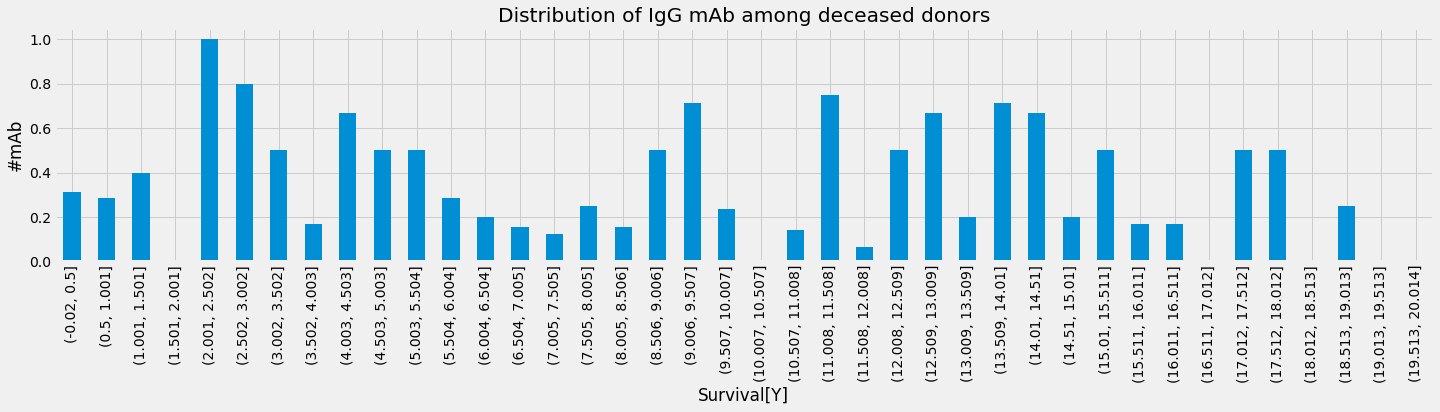

In [321]:
import numpy as np
bins = np.arange(0, 20, 0.5)
desa = DESA()
desa.include_mAb_data().donor_type('Deceased')
groupby = desa.df.groupby([pd.cut(desa.df['Survival[Y]'], 40)])
ax = (groupby['#mAb'].sum() / groupby['#mAb'].count()).plot.bar(figsize=(22, 4));
ax.set_ylabel('#mAb')
ax.set_title('Distribution of IgG mAb among deceased donors');

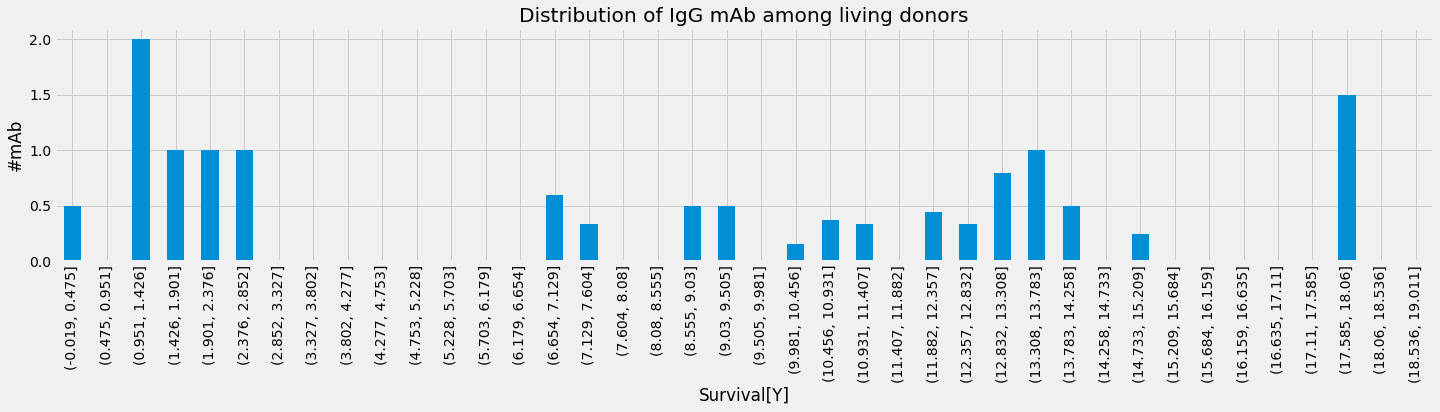

In [320]:
bins = np.arange(0, 20, 0.5)
desa = DESA()
desa.include_mAb_data().donor_type('Living')
groupby = desa.df.groupby([pd.cut(desa.df['Survival[Y]'], 40)])
ax = (groupby['#mAb'].sum() / groupby['#mAb'].count()).plot.bar(figsize=(22, 4));
ax.set_ylabel('#mAb')
ax.set_title('Distribution of IgG mAb among living donors');

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')